In [82]:
%pylab
%matplotlib inline
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
iris = load_iris()#导入iris数据集

data = iris.data
data = data[:100]
labels = iris.target
labels = labels[:100]
feature_name = iris.feature_names
print("feature_name", feature_name)

#我们选择了sepal length (cm)', 'sepal width (cm)'，并且更改了labels
data = data[:, 0:2]
labels[labels == 0] = -1
feature_name = feature_name[:2]

X_train, X_test, y_train, y_test = train_test_split(data, labels)#划分数据集

Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib
feature_name ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']


C:\Users\hichens\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['clf']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [83]:
class my_svm():
    def __init__(self, max_itr=10000, kernel_name='linear'):
        self.kernel_name = kernel_name #核函数名称
        self.max_itr = max_itr #最大迭代次数
        
    #输入参数
    def input_param(self, features, labels, C):
        #初始化参数， b=0， X为训练集， y为标签，C为惩罚系数， alp是alpha数组， E数组用来保存每个数据的预测值于真实值之差的
        self.b = 0
        self.m, self.n = features.shape #取得训练集的size
        self.X = features
        self.y = labels
        
        self.alp = np.zeros(self.m)
        self.C = C
        self.E = np.array([self.E_function(i) for i in range(self.m)])
        
    #计算每个数据的预测值
    def g_function(self, i):
        temp = self.b
        xi = self.X[i]
        for j in range(self.m):
            xj = self.X[j]
            temp += self.alp[j]*self.y[j]*self.kernel(xi, xj)
        return temp
    
    #计算Ei值
    def E_function(self, i):
        return self.g_function(i) - self.y[i]
        
    #核函数
    def kernel(self, x, z):
        if self.kernel_name == 'linear':
            return np.dot(x, z)
        elif self.kernel_name == 'poly':
            return (np.dot(x, z) + 1)**2
        elif self.kernel_name == 'gaussian':
            #sigma = np.std(self.x)
            return np.exp(-(x-z)**2)
        return 0
    
    #学习率函数 ，用来更新alpha2
    def lr_function(self, x1, x2):
        return self.kernel(x1, x1) + self.kernel(x2, x2) - 2*self.kernel(x1, x2)
    
    #KKT条件
    def KKT(self, i):
        temp = self.y[i]*self.g_function(i)
        alp = self.alp[i]
        if alp == 0:
            return temp >= 1
        elif alp == self.C:
            return temp <= 1
        else:
            return temp == 1
    
    def clip(self, alp2_new_unc, alp1_old, alp2_old, y1, y2):
        #限制条件L， H
        if y1 != y2:
            L = max(0, alp2_old - alp1_old)
            H = min(self.C, self.C + alp2_old + alp1_old)
        else:
            L = max(0, alp2_old + alp1_old - self.C)
            H = min(self.C, alp2_old + alp1_old)
            
        #是否更新alp2
        alp2_new = alp2_new_unc
        if alp2_new_unc > H:
            alp2_new = H
        elif alp2_new_unc < L:
            alp2_new = L
        return alp2_new
        
    def fit(self, X, y, C=1):
        self.input_param(X, y, C)#初始化参数

        for itr in range(self.max_itr):
            for i in range(self.m):
                #不满足KKT条件则更新参数
                if not self.KKT(i):
                    b_old = self.b
                    alp1_old = self.alp[i]
                    y1 = self.y[i]
                    x1 = self.X[i]
                    E1 = self.E[i]

                    #alp2的选择
                    j = np.argmax(np.abs(self.E - E1))#E2要选择使得|E1 - E2|最大的
                    alp2_old = self.alp[j]
                    y2 = self.y[j]
                    E2 = self.E[j]
                    x2 = self.X[j]
                    
                    # 更新alp1,alp2
                    lr = self.lr_function(x1, x2)
                    alp2_new_unc = alp2_old + y2*(E1 - E2)/lr
                    
                    alp2_new = self.clip(alp2_new_unc, alp1_old, alp2_old, y1, y2)
                    alp1_new = alp1_old +y1*y2*(alp2_old - alp2_new) 
                    
                    #更新b1, b2
                    b1_new = -E1 - y1*self.kernel(x1, x1)*(alp1_new - alp1_old) - y2*self.kernel(x2, x1)*(alp2_new - alp2_old) + b_old
                    b2_new = -E2 - y1*self.kernel(x1, x2)*(alp1_new - alp1_old) - y2*self.kernel(x2, x2)*(alp2_new - alp2_old) + b_old
                    
                    if 0 < alp1_new < self.C:
                        b_new = b1_new
                    elif 0 < alp2_new < self.C:
                        b_new = b2_new
                    else:
                        b_new = (b1_new + b2_new)/2
                    
                    #保存更新的参数
                    self.alp[i] = alp1_new
                    self.alp[j] = alp2_new
                    self.b = b_new
                    self.E[i] = self.E_function(i)
                    self.E[j] = self.E_function(j)

        return 'training done !'

    def predict(self, X):
        res = []
        for x in X:
            #temp从b开始累加
            temp = self.b
            for i in range(self.m):
                temp += self.alp[i]*self.y[i]*self.kernel(x, self.X[i])
            r = 1 if temp > 0 else -1
            res.append(r)
        return np.array(res)

    def score(self, X, y):
        y_pred = self.predict(X)
        return np.mean(y_pred == y)

    def weight(self):
        return np.dot(self.alp, self.y.reshape(-1, 1)*self.X)

In [84]:
clf = my_svm(10)
clf.fit(X_train, y_train)

clf.score(X_test, y_test)

w = clf.weight()
b = clf.b
w, b

C:\Users\hichens\Anaconda3\lib\site-packages\ipykernel_launcher.py:96: RuntimeWarning: divide by zero encountered in double_scalars


(array([ 4.13749279, -2.17763386]), -16.659548382733714)

In [85]:
x = X_train
y = y_train

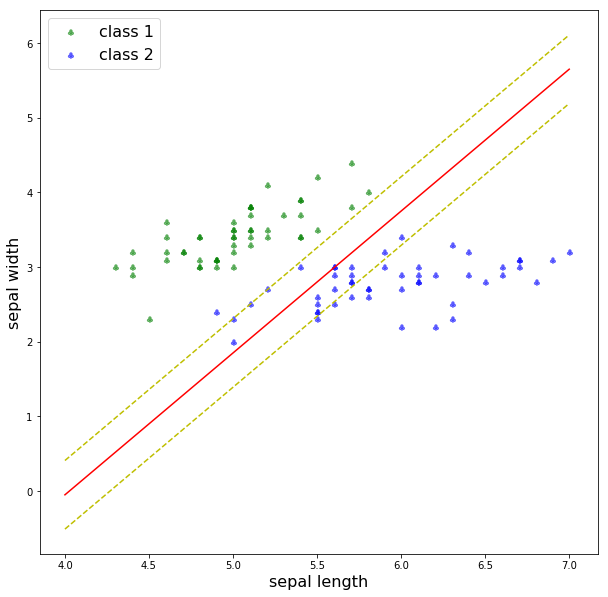

In [86]:
x_ponits = np.arange(4, 8)
y_ = -(w[0]*x_ponits + b)/w[1]
plt.figure(figsize=(10, 10))

plt.plot(x_ponits, y_, 'r')
plt.plot(x_ponits, y_+1/w[1], 'y--')
plt.plot(x_ponits, y_-1/w[1], 'y--')

plt.scatter(data[labels == -1][:, 0], data[labels == -1][:, 1],c="g", alpha=0.5, marker=r'$\clubsuit$',
            label="class 1")
plt.scatter(data[labels == 1][:, 0], data[labels == 1][:, 1], c="b", alpha=0.5, marker=r'$\clubsuit$',
            label="class 2")
plt.xlabel('sepal length',fontsize=16)
plt.ylabel('sepal width', fontsize=16)
plt.legend(fontsize=16)